<a href="https://colab.research.google.com/github/johannes-kk/am207/blob/master/exercises/08_MH_and_Gibbs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DAY 8: Metropolis-Hastings and Gibbs Sampling


### AM207: Advanced Scientific Computing

#### Instructor: Weiwei Pan

#### Due: September 29th, 11:59pm EST

**Names of Group Members**: 

Owen Callen (owencallen@gmail.com)

Johannes Kolberg, johanneskolberg@g.harvard.edu

Angie Dinh (ngd008@g.harvard.edu)

Kaivalya Rawal: kaivalyarawal@g.harvard.edu

Maggie Wang (maggiewang@college.harvard.edu)

Zeren Long (zeren_long@g.harvard.edu)

## Learning Goals:

1. Explore the efficiency of the Gibbs sampler as a function of the geometry of the target distribution
2. Compare the performance of Gibbs and Metropolis-Hastings samplers
3. Explore the efficiency of Metropolis-Hastings samplers as a function of the geometry of the target distribution
4. Evaluate the performance of samplers use convergence tools


### Load necessary libraries

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures
import scipy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
%matplotlib inline

## Problem 1: Gibbs versus Metrpolis-Hastings

In this problem you will explore how the shape of the target distribution affect the behavious of the Gibbs sampler.

First, implement a Gibbs sampler to sample from the following bivariate Gaussian:

$$
\mathcal{N}\left([120, 4], \left[\begin{array}{cc} 3& 1\\ 1 & 3 \end{array} \right] \right)
$$

Let's denote the first component, $X_1$, of $\mathbf{X}$, by $X$ and the second component, $X_2$, by $Y$.

Now, if $X$ and $Y$ are jointly normally distributed with $\mu = [\mu_X, \mu_Y]$ and $\Sigma = \left[\begin{array}{cc}\sigma^2_X & \rho\sigma_X\sigma_Y\\\rho\sigma_X\sigma_Y & \sigma^2_Y\end{array}\right]$. The conditionals $p(Y | X) = f_{Y\vert X}$ and $p(X | Y) = f_{X\vert Y}$ are both normal with:
\begin{align}
\mathbb{E}[Y|x] &= \mu_Y + \rho\frac{\sigma_Y}{\sigma_X}(X - \mu_X), &\text{Var}[Y|x] = \sigma_Y^2(1 - \rho)\\
\mathbb{E}[X|y] &= \mu_X + \rho\frac{\sigma_X}{\sigma_Y}(Y - \mu_Y), &\text{Var}[X|y] = \sigma_X^2(1 - \rho)
\end{align}

***Note:*** The derivation of these forms are algebraically involved but not difficult, you are encouraged to do it by hand once (following online notes if you'd like) to get a flavor of how to manipulate Gaussian distributions.

In our case, we see that we have $\mu_X = 120, \mu_Y = 4$, $\sigma_X = \sigma_Y = \sqrt{3}$. Then we have $\rho = \frac{\text{Cov}[X, Y]}{\sigma_X\sigma_Y} = \frac{1}{3}$.

Finally, we have that our two conditionals are:

\begin{align}
p(Y | X) &= \mathcal{N}\left( \mu_Y + \rho\frac{\sigma_Y}{\sigma_X}(X - \mu_X), \sigma_Y^2(1 - \rho)\right)\\
p(X | Y) &= \mathcal{N}\left( \mu_X + \rho\frac{\sigma_X}{\sigma_Y}(Y - \mu_Y), \sigma_X^2(1 - \rho) \right)
\end{align}



**Exercise 1:** Scatter plot the samples with the Gaussian pdf, connect consecutive samples with a line so that you can see how the sampler moves in the sample space. 

Check for convergence of your chain. Apply the appropriate amount of burn-in and thinnning to an appropriate choice of number of total samples.

Explore the effect of your choice of initialization on the performance of your sampler.

Now, implement a Gibbs sampler to sample from a different bivariate Gaussian:

$$
\mathcal{N}\left([120, 4], \left[\begin{array}{cc} 10.2& 10\\ 10 & 10.2 \end{array} \right] \right)
$$

Again, scatter plot the samples with the Gaussian pdf, connect consecutive samples with a line so that you can see how the sampler moves in the sample space. 

Discuss how the shape of the Gaussian affects the performance of the sampler. How do you explain what you observe?

In [ ]:
# Read in some example samples from a Gibbs sampler
samples = pd.read_csv('https://raw.githubusercontent.com/onefishy/am207/master/Labs/datasets/samples.csv', delimiter=',')
samples.head()

,x_1,x_2
0,120.159526,2.852736
1,119.552725,4.238285
2,121.750533,2.642016
3,121.238664,0.908990
4,120.875384,7.625327


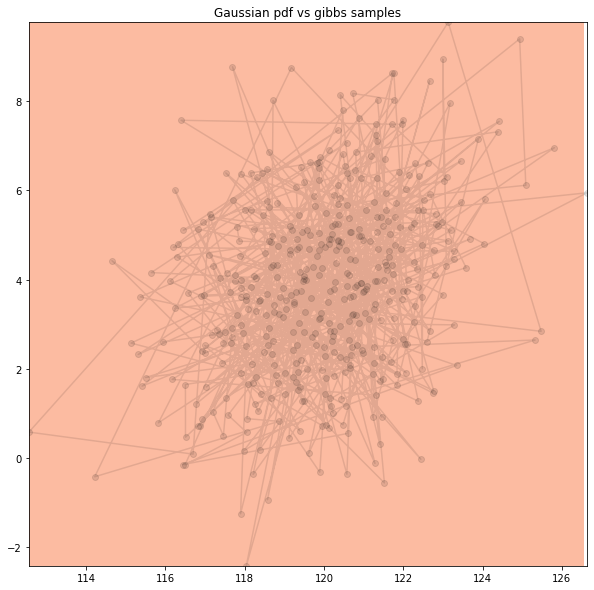

In [ ]:
# Extract the values from the data frame as an numpy array
gibbs_samples = samples.values

# Set the parameters of the target distribution
mu = [120, 4] # mean of the multivariate Gaussian
Sigma = np.ones((2, 2)) + 2 * np.eye(2) # covariance matrix of the multivariate Gaussian

# Define grid points that include most of the probability mass of the pdf
x, y = np.mgrid[gibbs_samples[:, 0].min():gibbs_samples[:, 0].max():.1, gibbs_samples[:, 1].min():gibbs_samples[:, 1].max():.01]
pos = np.dstack((x, y))
# Get the value of the pdf at these grid points
z = sp.stats.multivariate_normal(mu, Sigma).pdf(pos)

# Plot the target density against samples
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.contourf(x, y, z, levels=14, cmap='Reds') # plot contour map of the target pdf based on values at grid points
ax.scatter(gibbs_samples[:, 0], gibbs_samples[:, 1], color='black', alpha=0.1) # scatter plot the samples from the sampler
ax.plot(gibbs_samples[:, 0], gibbs_samples[:, 1], color='black', alpha=0.1) # draw lines connecting consecutive samples

ax.set_title('Gaussian pdf vs gibbs samples') # set title
ax.set_xlim([gibbs_samples[:, 0].min(), gibbs_samples[:, 0].max()])
ax.set_ylim([gibbs_samples[:, 1].min(), gibbs_samples[:, 1].max()])
plt.show() # display the figure

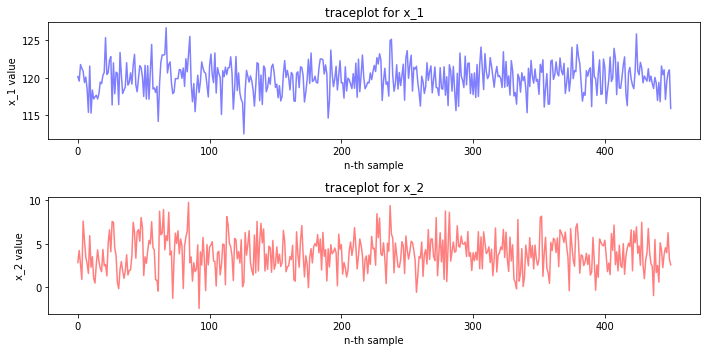

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
ax[0].plot(np.arange(gibbs_samples.shape[0]), gibbs_samples[:, 0], color='blue', alpha=0.5) # plot the trace plot for x_1
ax[0].set_xlabel('n-th sample') # set x-axis label
ax[0].set_ylabel('x_1 value') # set y-axis label
ax[0].set_title('traceplot for x_1') # set the title

ax[1].plot(np.arange(gibbs_samples.shape[0]), gibbs_samples[:, 1], color='red', alpha=0.5) # plot the trace plot for x_2
ax[1].set_xlabel('n-th sample') # set x-axis label
ax[1].set_ylabel('x_2 value') # set y-axis label
ax[1].set_title('traceplot for x_2') # set the title

plt.tight_layout() # layout the subplots nicely
plt.show() # display the figure

\begin{align}
p(Y | X) &= \mathcal{N}\left( \mu_Y + \rho\frac{\sigma_Y}{\sigma_X}(X - \mu_X), \sigma_Y^2(1 - \rho)\right)\\
p(X | Y) &= \mathcal{N}\left( \mu_X + \rho\frac{\sigma_X}{\sigma_Y}(Y - \mu_Y), \sigma_X^2(1 - \rho) \right)
\end{align}

In [ ]:
mu_x = 120
mu_y = 4
sig_x = np.sqrt(10.2)
sig_y = np.sqrt(10.2)
rho = 10/10.2
# sig_x = np.sqrt(3)
# sig_y = np.sqrt(3)
# rho = 1/3

old_x = 10
old_y = 4
yis = []
xis = []
for i in range(500):
  new_x = np.random.normal(mu_x +rho*sig_x/sig_y*(old_y- mu_y), sig_x*np.sqrt(1-rho))
  new_y = np.random.normal(mu_y +rho*sig_y/sig_x*(old_x- mu_x), sig_y*np.sqrt(1-rho))
  
  xis.append(new_x)
  yis.append(new_y)
  old_x, old_y = new_x, new_y

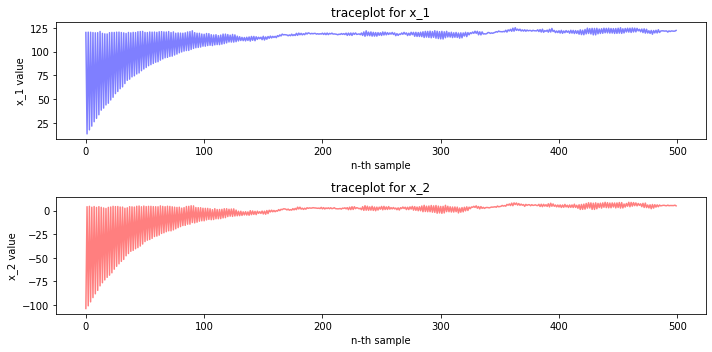

In [ ]:
def trace_plot(xis, yis):
  fig, ax = plt.subplots(2, 1, figsize=(10, 5))
  ax[0].plot(np.arange(len(xis)), xis, color='blue', alpha=0.5) # plot the trace plot for x_1
  ax[0].set_xlabel('n-th sample') # set x-axis label
  ax[0].set_ylabel('x_1 value') # set y-axis label
  ax[0].set_title('traceplot for x_1') # set the title

  ax[1].plot(np.arange(len(yis)), yis, color='red', alpha=0.5) # plot the trace plot for x_2
  ax[1].set_xlabel('n-th sample') # set x-axis label
  ax[1].set_ylabel('x_2 value') # set y-axis label
  ax[1].set_title('traceplot for x_2') # set the title

  plt.tight_layout() # layout the subplots nicely
  plt.show() # display the figure
trace_plot(xis, yis)

The lack of a trend and the fact that we dont see the repeated values is a good indication that we have ether converged or gotten stuck in a high mass regon. If the target is bimodal we may not have converged.

**Exercise 2:** Implement a Metropolis-Hastings sampler for the two Gaussians in the Exercise 1. Keep track of the acceptance rate.

Try a bivariate Gaussian proposal distribution $\mathcal{N}(X_n, \sigma^2I_{2\times 2})$, where $I_{2\times 2}$ is the identity matrix, $X_n$ is the current sample and $\sigma^2$ is your choice of variance. Try different values of $\sigma$.

Discuss how does the shape of the Gaussian effect the performance of your sampler.

How does MH perform in comparison to Gibbs?

Try a bivariate Gaussian proposal distribution 
$$
\mathcal{N}\left(X_n, \left[\begin{array}{cc} 0.4& 0.2\\ 0.2 & 0.4 \end{array} \right] \right)
$$
where $X_n$ is the current sample. 

Does this proposal distribution perform better or worse than $\mathcal{N}(X_n, \sigma^2I_{2\times 2})$? Why do you think it does (or does not)?

---
## Problem 2: Convergence Diagnostics for Metropolis-Hastings

Recall the mixture of two univariate Gaussian example in class where our Metropolis-Hastings sampler was unable to capture both modes in the target distribution.

Is this because this algorithm is incapable of sampling from this specific distribution of this class of ***multimodal distributions***? Or did we make inappropriate design choices when we specified our sampler?

**Exercise 3:** Play with the variance of the normal proposal distribution (try some very small values and some very large values), what is the effect of the variance have on the performance of your sampler? 

Play with the choice of initialization of the Metropolis-Hastings algorithm, what is the effect of the initialization on the performance of your sampler?

In [ ]:
# Read in some example samples from two MH samplers
samples1 = pd.read_csv('https://raw.githubusercontent.com/onefishy/am207/master/Labs/datasets/MH_samples1.csv', delimiter=',').values
samples2 = pd.read_csv('https://raw.githubusercontent.com/onefishy/am207/master/Labs/datasets/MH_samples2.csv', delimiter=',').values

In [ ]:
#visualize target distribution and samples
def plot_samples(ax, target, samples, title):
    x = np.linspace(-5, 25, 100)
    ax.plot(x, target(x), color='black', alpha=0.9, label='target distribution')
    ax.hist(samples, density=True, bins=50, color='red', alpha=0.5, label='all samples')
    ax.set_title(title)
    ax.legend(loc='best')
    return ax

# Define the target distribution as a mixture of two univariate gaussians
sigma_sqs = [1, 1] # define the variances of the mixture components
mus = [2, 20] # define the means of the mixture components
pis = [0.5, 0.5] # define the proportions of the two components
target = lambda x: pis[0] * sp.stats.norm(mus[0], sigma_sqs[0]**0.5).pdf(x) + pis[1] * sp.stats.norm(mus[1], sigma_sqs[1]**0.5).pdf(x) # define the target pdf

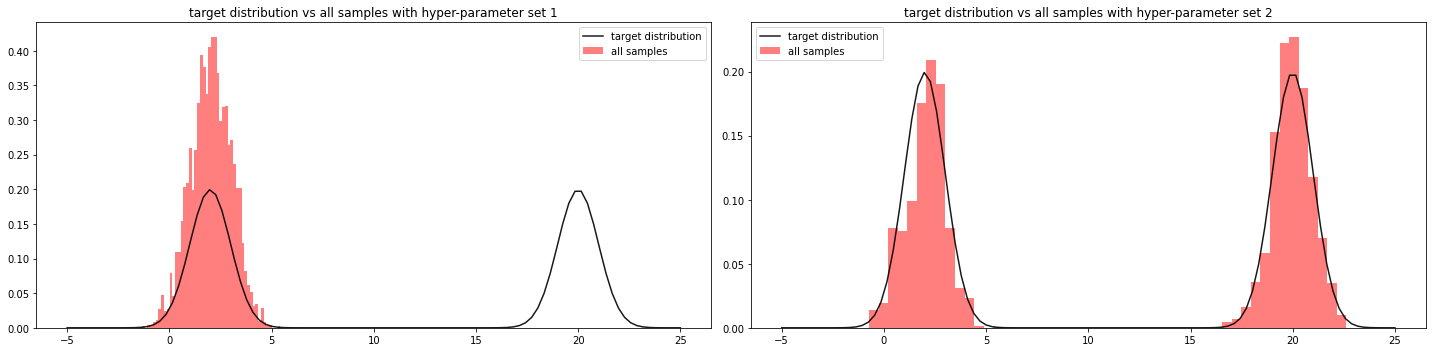

In [ ]:
# Plot samples from different samplers against the target distribution
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
x = np.linspace(-5, 25, 100) # generate a range of input values for plotting the pdf
ax[0] = plot_samples(ax[0], target, samples1[200:], 'target distribution vs all samples with hyper-parameter set 1') # plot the samples from the first sampler
ax[1] = plot_samples(ax[1], target, samples2[200:], 'target distribution vs all samples with hyper-parameter set 2') # plot the samples from the second sampler
plt.tight_layout() # layout the subplots nicely
plt.show() # display the figuref

1. If the variance of the normal proposal distribution is low, the resulting MH sample may not capture the characteristics of the target distribution. Like the graph 1 above. The nomal proposal distribution has a low variance, and thus the resulting MH samples just cluster around one mode. On the contrary, if the variance of the nomal proposal distribution is high, which means the sample may spread widely, and thus the resulting MH samples may capture target distribution.
2. How we initialize the MH sampler may affect the result of sampling process. If we don't make the correct initialization, the resulting samples may be quite different from the target distribution.

**Exercise 4:** Compare the trace-plots of the MH sampler for your different choices of the proposal distribution. Are you able to use the traceplots to diagnose convergence for this sampler and this target distribution? What does this indicate about the ability of convergence diagnostics to inform us of the convergence of our samplers for general target distribution (imagine if you can't visualize the target distribution).

Would auto-correlation plots be able to diagnose (failure of) convergence for multi-modal target distributions? What about the Gelman & Rubin metric or the Geweke metric -- would they be better diagnostic tools for diagnosing convergence failures?